### 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

os.chdir("../")
from scripts import utils
from pathlib import Path
import matplotlib.gridspec as gridspec
from tqdm.auto import tqdm

In [2]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from mlxtend.evaluate import feature_importance_permutation
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils.estimator_checks import check_estimator
from mlxtend.feature_selection import (
    SequentialFeatureSelector,
)
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import matplotlib.ticker as ticker
import distclassipy as dcpy

In [4]:
with open("settings.txt") as f:
    settings_dict = json.load(f)
seed_val = settings_dict["seed_choice"]
np.random.seed(seed_val)
sns_dict = settings_dict["sns_dict"]
sns.set_theme(**sns_dict)

In [5]:
all_metrics = settings_dict["all_metrics"]

In [6]:
features = pd.read_parquet("data/reduced_balancedfeatures_LATEST.parquet")
features["class"].value_counts()

class
CEP     683
DSCT    683
EB      683
RRL     683
Name: count, dtype: int64

In [7]:
features = features.sample(frac=1)

In [8]:
y_df = features["class"]
X_df = features.drop(["Coordinate_x", "Coordinate_y", "Coordinate_z", "class"], axis=1)

In [9]:
y = y_df.to_numpy()
X = X_df.to_numpy()

### 1. Isolation Forest

In [10]:
from sklearn.ensemble import IsolationForest
from scipy import stats

In [11]:
clf = IsolationForest(max_samples=100, contamination=0.1, random_state=100)
clf.fit(X) #, sample_weight=1.0/(Xfixed[:,2,:])**2)
scores_pred_Norm = clf.decision_function(X)
#scores_pred_Norm = clf.score_samples(X)
#.sample_score(X)

threshold_Norm  = stats.scoreatpercentile(scores_pred_Norm ,100 * 0.1)
y_predNorm = clf.predict(X)

In [12]:
abornmality = -scores_pred_Norm
iforest_df = pd.DataFrame(abornmality, columns=["abnormality"]) # higher is more abnormal
iforest_df.index.name = "sample_num"
iforest_df=iforest_df.sort_values(by="abnormality", ascending=False)

In [13]:
iforest_df

,abnormality
sample_num,
817,0.146213
2157,0.138299
1969,0.128877
157,0.122814
2543,0.118233
...,...
1220,-0.135107
1320,-0.135398
1806,-0.135956


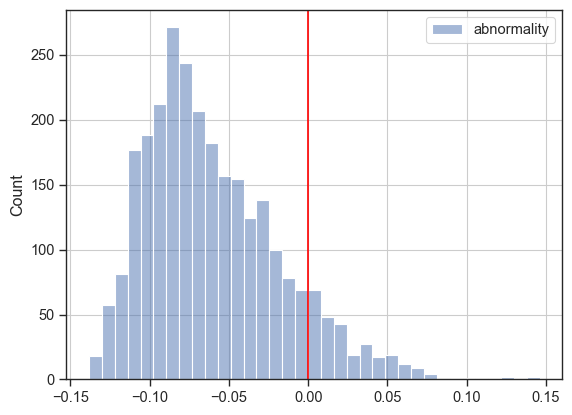

In [14]:
sns.histplot(iforest_df)
plt.axvline(x=0, color="red",label="outlier boundary")
plt.show()

### 2. Single DCPY Mean Distance

In [15]:
lcdc = dcpy.DistanceMetricClassifier(
    scale=True,
    central_stat="median",
    dispersion_stat="std",
)
lcdc.fit(X,y)

DistanceMetricClassifier()

In [16]:
for metric in tqdm(all_metrics, desc="Metric", leave=True):
    metric_str = utils.get_metric_name(metric)
    _ = lcdc.predict_and_analyse(X, metric=metric)

    dist_df = lcdc.centroid_dist_df_
    break

Metric:   0%|          | 0/18 [00:00<?, ?it/s]

In [17]:
dist_df['closest_distance'] = dist_df.min(axis=1)

# standard scale w/mean?
# mean = dist_df['closest_distance'].mean()
# std  = dist_df['closest_distance'].std()
# dist_df['abnormality_mean'] = (dist_df['closest_distance'] - mean) / std

# # standard scale w/median?
# med = dist_df['closest_distance'].median()
# mad = stats.median_abs_deviation(dist_df['closest_distance'])
# dist_df['abnormality_median'] = (dist_df['closest_distance'] - med) / mad

dist_df.index.name = "sample_num"
# dist_df=(dist_df.sort_values(by="abnormality_mean",ascending=False))

In [18]:
dist_df

,CEP_dist,DSCT_dist,EB_dist,RRL_dist,closest_distance
sample_num,,,,,
0,9.321139,36.965617,7.273588,15.369049,7.273588
1,12.154993,8.064894,8.341930,10.385771,8.064894
2,11.035024,9.521399,9.855522,12.161613,9.521399
3,7.383865,6.206982,10.781571,8.848973,6.206982
4,12.593742,12.264024,7.636605,14.579765,7.636605
...,...,...,...,...,...
2727,8.200780,101.033819,533.902923,201.115122,8.200780
2728,15.069851,68.443813,12.643946,9.366479,9.366479
2729,5.120270,116.805311,263.229780,120.963450,5.120270


In [20]:
# sns.histplot(dist_df,x="abnormality_median")
# sns.histplot(dist_df,x="abnormality_mean")
# plt.axvline(x=0, color="red")
# # plt.yscale("log")
# plt.show()

In [21]:
# dist_df["abnormality_iforest"] = iforest_df.loc[dist_df.index]

In [22]:
# anomaly_df = dist_df.loc[:,["abnormality_mean","abnormality_median","abnormality_iforest"]]
# anomaly_df=anomaly_df.sort_values(by=["abnormality_mean","abnormality_median","abnormality_iforest"],ascending=False)

In [23]:
# anomaly_df[(anomaly_df["abnormality_mean"] > 0) | (anomaly_df["abnormality_median"] > 0) | (anomaly_df["abnormality_iforest"] > 0)]

In [24]:
# from sklearn.preprocessing import MinMaxScaler

In [24]:
# for col in anomaly_df.columns:
#     scaler = MinMaxScaler(feature_range=(-1, 1))
#     anomaly_df[col] = scaler.fit_transform(anomaly_df[[col]]).ravel()

<Axes: ylabel='sample_num'>

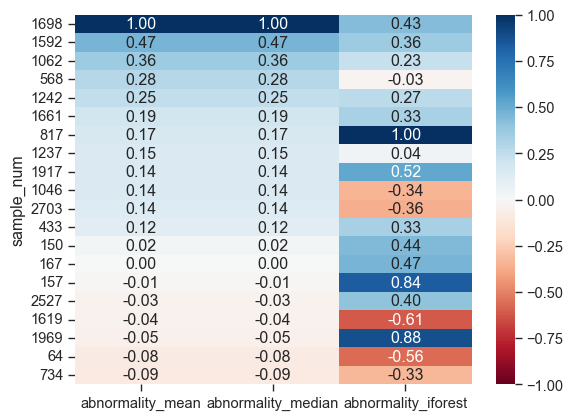

In [25]:
# sns.heatmap(anomaly_df.iloc[:20],cmap="RdBu", annot=True, fmt=".2f",vmin=-1,vmax=1)

<Axes: ylabel='sample_num'>

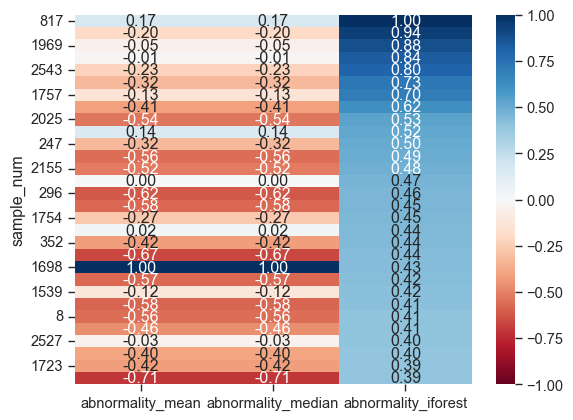

In [26]:
# sns.heatmap(anomaly_df.sort_values("abnormality_iforest",ascending=False).iloc[:30],cmap="RdBu", annot=True, fmt=".2f",vmin=-1,vmax=1)

### 3. Many DCPY Distance

In [35]:
dist_df_dict = {}
for metric in tqdm(all_metrics, desc="Metric", leave=True):
    metric_str = utils.get_metric_name(metric)
    _ = lcdc.predict_and_analyse(X, metric=metric)

    dist_df = lcdc.centroid_dist_df_

    dist_df['closest_distance'] = dist_df.min(axis=1)
    
    # standard scale w/mean?
    # mean = dist_df['closest_distance'].mean()
    # std  = dist_df['closest_distance'].std()
    # dist_df['abnormality_mean'] = (dist_df['closest_distance'] - mean) / std
    
    # standard scale w/median?
    # med = dist_df['closest_distance'].median()
    # mad = stats.median_abs_deviation(dist_df['closest_distance'])
    # dist_df['abnormality_median'] = (dist_df['closest_distance'] - med) / mad
    
    dist_df.index.name = "sample_num"
    #dist_df=(dist_df.sort_values(by="abnormality_mean",ascending=False))
    dist_df_dict[metric_str] = dist_df

Metric:   0%|          | 0/18 [00:00<?, ?it/s]

Index(['CEP', 'DSCT', 'EB', 'RRL'], dtype='object')

In [52]:
n_metrics = len(all_metrics)
clusters = dist_df.columns[:-1].str.replace("_dist","")
n_clusters =len(clusters)
n_objects = dist_df.shape[0]



9.321139152642035

In [55]:
dist_df_arr = np.zeros((n_objects, n_clusters, n_metrics))
for i in range(n_objects):
    for j, cluster in enumerate(clusters):
        for k, metric in enumerate(all_metrics):
            metric_str = utils.get_metric_name(metric)
            dist_df_arr[i, j, k] = dist_df_dict[metric_str].loc[i,f"{cluster}_dist"]

In [31]:
# bigarr = []
# for metric in tqdm(all_metrics, desc="Metric", leave=True):
#     metric_str = utils.get_metric_name(metric)
#     bigarr.append(dist_df_dict[metric_str].loc[:,["abnormality_mean","abnormality_median"]].to_numpy())

bigarr = []
bigdf = pd.DataFrame(index=dist_df.index)

for metric in tqdm(all_metrics, desc="Metric", leave=True):
    metric_str = utils.get_metric_name(metric)
    dist = dist_df_dict[metric_str].loc[:,["closest_distance"]].to_numpy()
    bigarr.append(dist)
    bigdf[f"min_{metric_str}"] = dist

Metric:   0%|          | 0/18 [00:00<?, ?it/s]

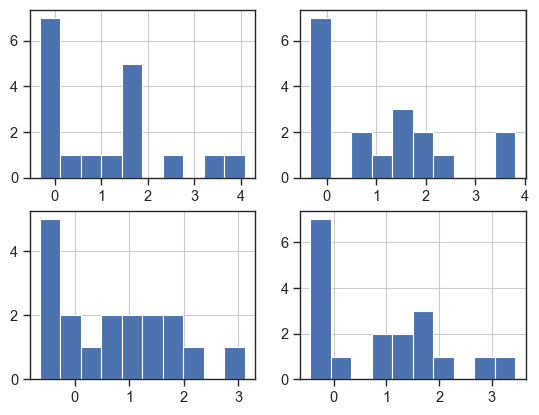

In [109]:
objnum = np.random.randint(1000)
fig, ax = plt.subplots(2,2)
axs = ax.ravel()
for j, cluster in enumerate(clusters):
    axs[j].hist(np.log10(dist_df_arr[objnum,j,:]))
    # axs[j].set_xscale("log")

In [115]:
pd.DataFrame(np.log10(dist_df_arr[objnum]))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.810003,-0.191104,1.692701,2.348315,1.649621,0.811176,-0.079351,-0.177542,1.247887,-0.056083,1.819558,-0.319685,3.558590,-0.085124,-0.105980,1.734542,0.558494,4.083294
1,1.839600,-0.191537,1.649276,2.388460,1.630073,0.776139,-0.009041,-0.145313,1.260038,-0.037775,1.828980,-0.324041,3.565603,-0.085294,-0.106243,1.704819,0.557278,3.807396
2,1.054792,-0.403368,1.596229,1.815590,0.553591,0.735189,-0.330943,-0.580677,0.887915,-0.340896,1.582428,-0.641601,2.188682,-0.156446,-0.246922,1.664261,0.115930,3.120837
3,1.442368,-0.329515,1.663970,2.170970,1.152009,0.784531,-0.270646,-0.439469,1.088760,-0.273101,1.803010,-0.439469,2.961233,-0.134228,-0.195287,1.717444,0.245813,3.445250


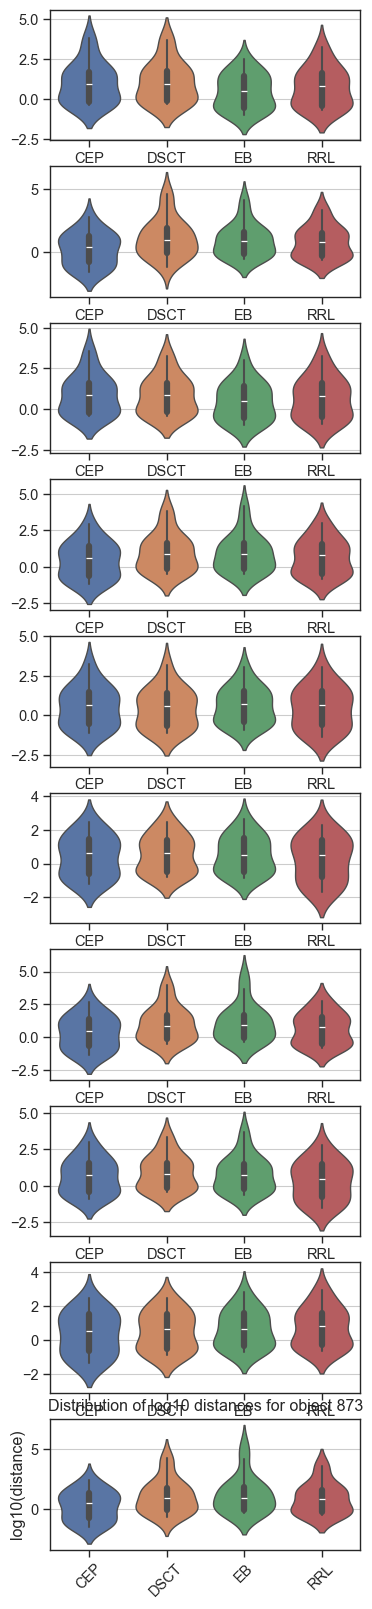

In [131]:
fig, axs = plt.subplots(10, 1, figsize=(4, 20))
axs = axs.ravel()
for i, objnum in enumerate(np.random.randint(1000,size=10)):
    sns.violinplot(data=pd.DataFrame(np.log10(dist_df_arr[objnum]).T, columns=clusters),ax=axs[i])
    plt.title(f'Distribution of log10 distances for object {objnum}')
    plt.ylabel('log10(distance)')
    plt.xticks(rotation=45)

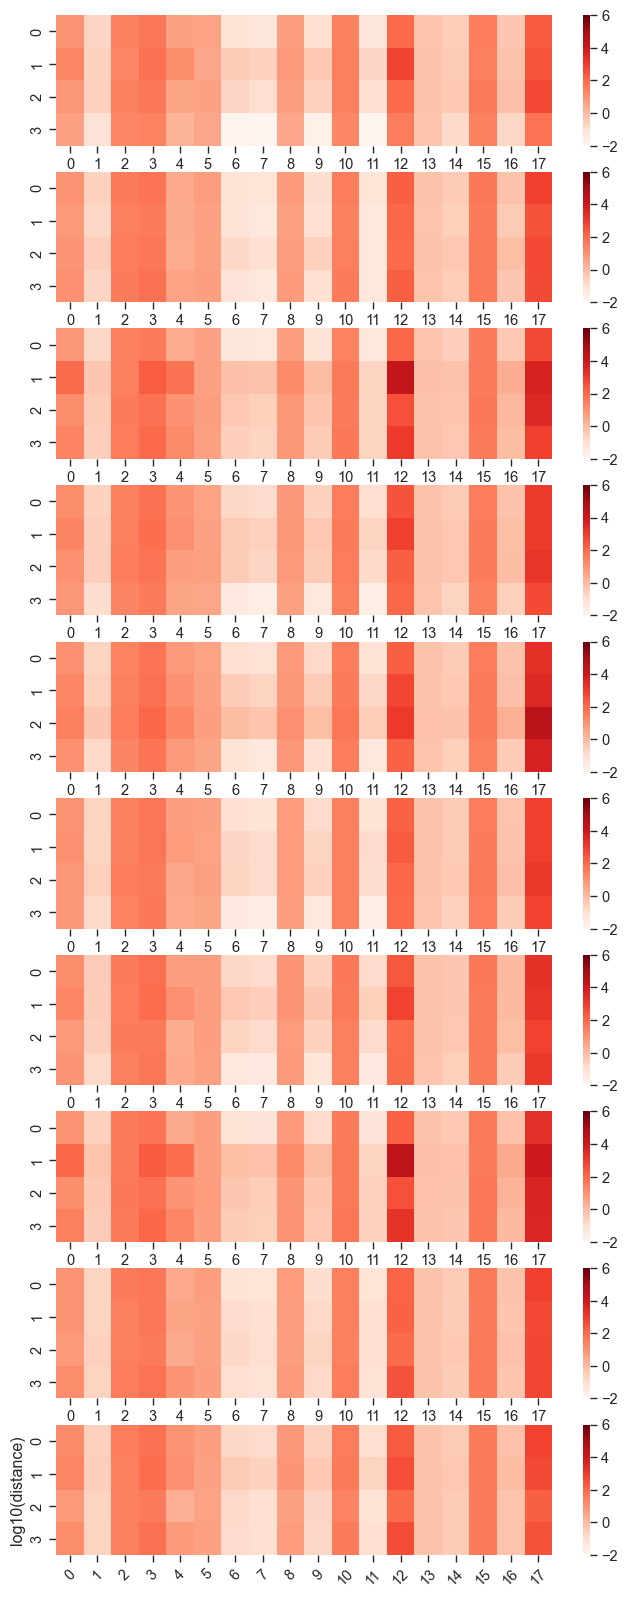

In [149]:
fig, axs = plt.subplots(10, 1, figsize=(8, 20))
axs = axs.ravel()
for i, objnum in enumerate(np.random.randint(1000,size=10)):
    sns.heatmap(np.log10(dist_df_arr[objnum]),cmap="Reds",ax=axs[i], vmin=-2, vmax=6)
    plt.ylabel('log10(distance)')
    plt.xticks(rotation=45)

In [102]:
bigdf

,min_Euclidean,min_Braycurtis,min_Canberra,min_Cityblock,min_Chebyshev,min_Clark,min_Correlation,min_Cosine,min_Hellinger,min_Jaccard,min_Lorentzian,min_Marylandbridge,min_Meehl,min_Motyka,min_Soergel,min_Wave_Hedges,min_Kulczynski,min_Add_Chisq
sample_num,,,,,,,,,,,,,,,,,,
0,7.273588,0.237975,34.602902,42.011152,2.914352,4.864062,0.081617,0.061314,5.341428,0.120539,28.441805,0.058485,91.094850,0.618988,0.384459,41.698004,0.624587,404.279487
1,8.064894,0.184020,24.146613,44.067408,3.016606,3.695620,0.064540,0.045587,5.391751,0.091027,28.602736,0.043487,101.748877,0.592010,0.310839,31.824200,0.451039,556.399929
2,9.521399,0.198998,21.828478,43.599860,4.163061,3.626807,0.083187,0.061891,6.249871,0.121454,25.809791,0.059121,166.106724,0.599499,0.331941,28.234174,0.496873,903.877392
3,6.206982,0.146864,21.290245,32.309256,3.115292,3.580184,0.053568,0.037776,3.959370,0.073837,22.535908,0.037218,57.787441,0.573432,0.256114,27.501042,0.344292,370.262014
4,7.636605,0.240290,27.274647,38.983495,4.388393,4.171830,0.140714,0.104340,5.559162,0.200167,25.500742,0.097413,135.570456,0.620145,0.387474,34.229759,0.632585,613.418726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,8.200780,0.198441,24.132243,43.563511,4.271590,3.845370,0.068560,0.051384,5.618626,0.098772,27.876929,0.050816,114.380886,0.599221,0.331166,31.023361,0.495139,887.485317
2728,9.366479,0.155928,20.997486,50.162546,5.088695,3.643403,0.055771,0.041046,5.916950,0.078953,31.398497,0.040994,136.671524,0.577964,0.269788,26.831403,0.369465,883.990829
2729,5.120270,0.120730,19.996179,26.010372,2.656580,3.410269,0.027211,0.020501,4.004853,0.040432,18.761889,0.020368,55.192534,0.560365,0.215449,26.198774,0.274615,597.393120


In [ ]:
sns.pairplot

In [29]:
mean_alldist_abnormalities = np.array(bigarr).mean(axis=0)
median_alldist_abnormalities = np.median(np.array(bigarr),axis=0)

In [36]:
mean_alldist_abnormalities

array([[ 0.28805254,  0.78017964],
       [-0.19180428,  0.03116775],
       [-0.07777723,  0.55487099],
       ...,
       [-0.90448861, -1.40972525],
       [-0.70502303, -1.03157842],
       [ 0.3373628 ,  0.99292245]])

In [32]:
pd.DataFrame(data=[mean_alldist_abnormalities,median_alldist_abnormalities],index=dist_df_dict[metric_str].index)

ValueError: Must pass 2-d input. shape=(2, 2732, 2)